In [1]:
from IPython.display import clear_output
!pip install imutils
clear_output()

In [18]:
!pip install PyMaxflow

     |████████████████████████████████| 133kB 21.0MB/s 
  Created wheel for PyMaxflow: filename=PyMaxflow-1.2.13-cp36-cp36m-linux_x86_64.whl size=530631 sha256=a69e539cb4c1fffad0e1712b592ac97ceb5477b5a32dd104f027d2573470e683
  Stored in directory: /root/.cache/pip/wheels/07/ef/b7/4874553b1c89ab847f54da9bd80ae935455e125cda138903ae
Successfully built PyMaxflow


In [19]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping
import sys
import logging
from itertools import count, combinations
logger = logging.getLogger(__name__)
from maxflow.fastmin import aexpansion_grid_step, abswap_grid_step,energy_of_grid_labeling
init_notebook_mode(connected=True)
RANDOM_SEED = 123

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [4]:
!apt-get install tree
clear_output()
# create new folders
!mkdir TRAIN TEST VAL TRAIN/YES TRAIN/NO TEST/YES TEST/NO VAL/YES VAL/NO
!tree -d

.
├── drive
│   └── MyDrive
│       ├── Colab Notebooks
│       │   └── Deep Learning
│       ├── ed5080 lab experimments
│       │   ├── _17_oct_-_ex_3
│       │   ├── _2_2
│       │   ├── _23
│       │   ├── _8
│       │   ├── ex1_1
│       │   ├── ex1_10
│       │   ├── ex1_11
│       │   ├── ex1_12
│       │   ├── ex1_13
│       │   ├── ex1_15
│       │   ├── ex1_16
│       │   ├── ex1_17
│       │   ├── ex1_18
│       │   ├── ex1_19
│       │   ├── ex1_2
│       │   ├── ex1_3
│       │   ├── ex1_4
│       │   ├── ex1_5
│       │   ├── ex1_6
│       │   ├── ex1_7
│       │   ├── ex1_8
│       │   ├── ex1_9
│       │   ├── ex3_2
│       │   ├── ex3_2a
│       │   ├── ex3_5
│       │   ├── ex3_autocalib
│       │   ├── ex3_manualcalibration
│       │   ├── Exercise_3_q_2
│       │   ├── Final_bot_Program
│       │   ├── HelloWorld
│       │   ├── prximity_sensor
│       │   └── Sweep1
│       ├── ML Coding Exercises
│       │   ├── ex1
│       │   │   └── lib
│       │   │       └── 

In [5]:
IMG_PATH = '/content/drive/My Drive/Papers/brain_tumor_dataset/'
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    print(CLASS)
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        print(IMG_NUM)
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            print(img)
            print(n)
            if n < 5:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

no
98
/content/drive/My Drive/Papers/brain_tumor_dataset/no/10 no.jpg
0
/content/drive/My Drive/Papers/brain_tumor_dataset/no/1 no.jpeg
1
/content/drive/My Drive/Papers/brain_tumor_dataset/no/11 no.jpg
2
/content/drive/My Drive/Papers/brain_tumor_dataset/no/41 no.jpg
3
/content/drive/My Drive/Papers/brain_tumor_dataset/no/37 no.jpg
4
/content/drive/My Drive/Papers/brain_tumor_dataset/no/13 no.jpg
5
/content/drive/My Drive/Papers/brain_tumor_dataset/no/4 no.jpg
6
/content/drive/My Drive/Papers/brain_tumor_dataset/no/19 no.jpg
7
/content/drive/My Drive/Papers/brain_tumor_dataset/no/34 no.jpg
8
/content/drive/My Drive/Papers/brain_tumor_dataset/no/29 no.jpg
9
/content/drive/My Drive/Papers/brain_tumor_dataset/no/6 no.jpg
10
/content/drive/My Drive/Papers/brain_tumor_dataset/no/36 no.jpg
11
/content/drive/My Drive/Papers/brain_tumor_dataset/no/26 no.jpg
12
/content/drive/My Drive/Papers/brain_tumor_dataset/no/46 no.jpg
13
/content/drive/My Drive/Papers/brain_tumor_dataset/no/40 no.jpg
14
/

In [6]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()



In [20]:
def aexpansion_grid(D, V, max_cycles=None, labels=None):
    
    num_labels = D.shape[-1]
    
    if labels is None:
        # Avoid using too much memory.
        if num_labels <= 127:
            labels = np.int8(D.argmin(axis=-1))
        else:
            labels = np.int_(D.argmin(axis=-1))
    
    if max_cycles is None:
        rng = count()
    else:
        rng = range(max_cycles)
    
    better_energy = np.inf
    # Cycles.
    for i in rng:
        logger.info("Cycle {}...".format(i))
        improved = False
        # Iterate through the labels.
        for alpha in range(num_labels):
            energy, _ = aexpansion_grid_step(alpha, D, V, labels)
            strimproved = ""
            # Check if the better energy has been improved.
            if energy < better_energy:
                better_energy = energy
                improved = True
                strimproved = "(Improved!)"
            logger.info("Energy of the last cut (α={}): {:.6g} {}".format(alpha, energy, strimproved))
        
        # Finish the minimization when convergence is reached.
        if not improved:
            break
    return labels

In [41]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|██████████| 2/2 [00:00<00:00, 14.93it/s]

193 images loaded from TRAIN/ directory.
10 images loaded from TEST/ directory.
50 images loaded from VAL/ directory.


In [42]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

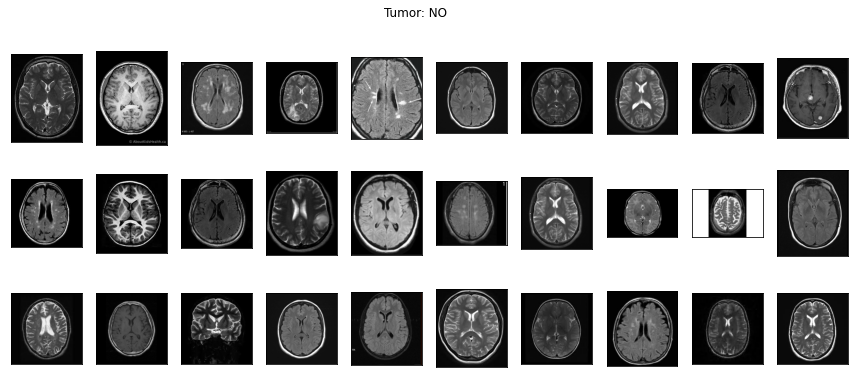

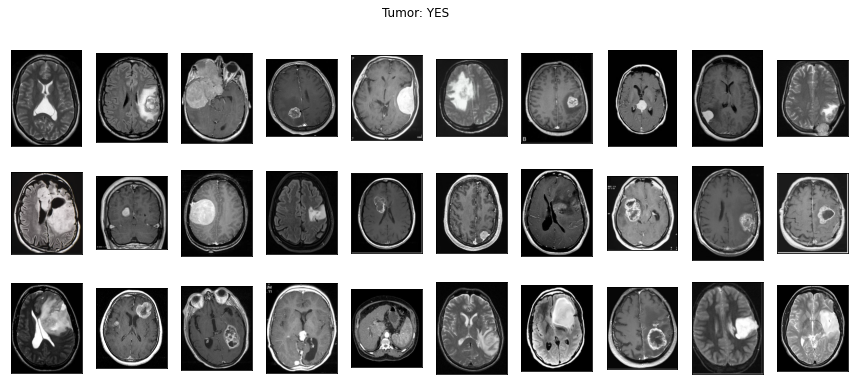

In [43]:
plot_samples(X_train, y_train, labels, 30)

In [46]:
def segment_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC
        )
        img = cv2.GaussianBlur(img, (5, 5), 0)
        img = img[:,:,1]/img.max()
        L = 2
        levs = np.arange(.5/L,1,1/L)
        D = np.abs(img.reshape(img.shape+(1,)) - levs.reshape((1,1,-1)))
        alpha =1
        V = alpha*np.abs(levs.reshape((-1,1))-levs.reshape(1,-1))
        new_img = aexpansion_grid(D,V)
        new_img = new_img.flatten()
        set_new.append(new_img)

    return np.array(set_new)

In [47]:
X_train = segment_imgs(set_name=X_train)
X_val = segment_imgs(set_name=X_val)
X_test = segment_imgs(set_name=X_test)

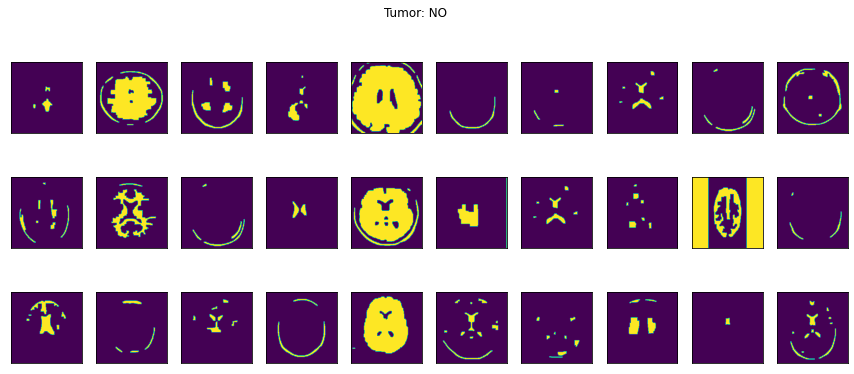

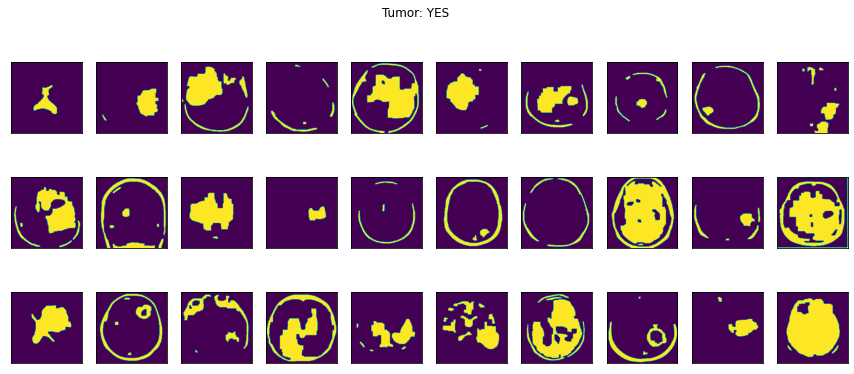

In [31]:
plot_samples(X_train, y_train, labels, 30)

In [48]:
from sklearn.svm import SVC
classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=0, shrinking=True, tol=0.001,
    verbose=False)

Val Accuracy = 0.80


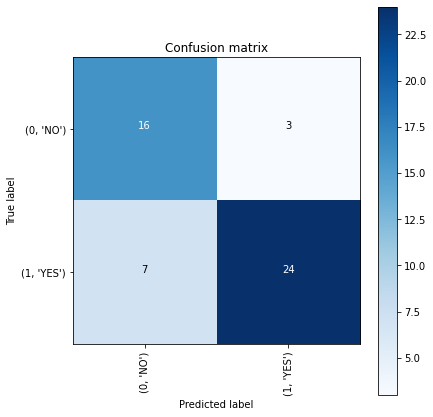

In [49]:
predictions = classifier.predict(X_val)

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_val, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)

Test Accuracy = 0.90


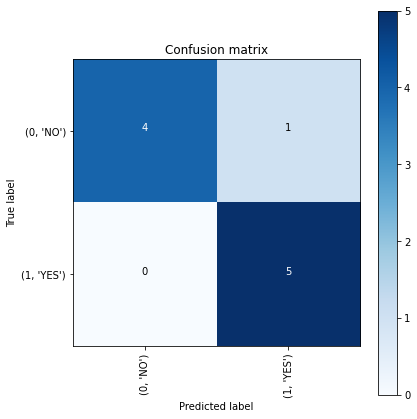

In [50]:
predictions = classifier.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

confusion_mtx = confusion_matrix(y_test, predictions) 
cm = plot_confusion_matrix(confusion_mtx, classes = list(labels.items()), normalize=False)